In [1]:
# !pip install opencv-python
import cv2 
from matplotlib import pyplot as plt 
import numpy as np
import pandas as pd
import easyocr
reader = easyocr.Reader(['en'])

C:\Users\Harini\AppData\Local\Temp\ipykernel_13116\917120140.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
self_cropped_image = "lp_cropped.png"
img = cv2.imread("yolo_cropped.png")
img_old = cv2.imread(self_cropped_image)

In [7]:
def display(im_path):
    dpi = 80
    im_data = plt.imread(im_path)
    # height, width, depth = im_data.shape

    figsize = im_data.shape[1] / float(dpi), im_data.shape[0] / float(dpi)

    fig = plt.figure(figsize = figsize)
    ax = fig.add_axes([0,0,1,1])

    ax.axis('off')

    ax.imshow(im_data, cmap='gray')

    plt.show()

In [63]:
# display(self_cropped_image)

Inverted Images

In [8]:
inverted_image = cv2.bitwise_not(img)
cv2.imwrite("inverted.png", inverted_image)
# display("inverted.png")



True

Rescaling -  optimised range, comes down to dpi, height of characters

Binarization - image should be in grayscale

In [9]:
def grayscale(image):
    return cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

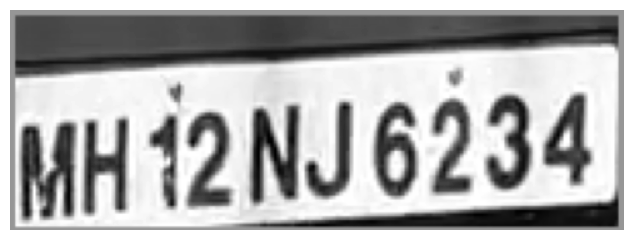

In [10]:
gray_image = grayscale(img)
cv2.imwrite("gray.png", gray_image)
# print(gray_image.shape)
display("gray.png")

In [67]:
thresh, im_bw1 = cv2.threshold(gray_image, 200, 255, cv2.THRESH_BINARY)
thresh, im_bw2 = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY)
thresh, im_otsu_og = cv2.threshold(gray_image, 64, 255, cv2.THRESH_OTSU)
thresh, im_otsu1 = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
thresh, im_otsu2 = cv2.threshold(gray_image, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

cv2.imwrite("im_bw1.png",im_bw1)
cv2.imwrite("im_bw2.png",im_bw2)
cv2.imwrite("im_otsu_og.png",im_otsu_og)
cv2.imwrite("im_otsu1.png",im_otsu1)
cv2.imwrite("im_otsu2.png",im_otsu2)

# display("im_bw1.png")
# display("im_otsu_og.png")
# display("im_otsu2.png")

True

Noise removal 

In [68]:
def noise_removal(image):
    kernel1 = np.ones((1,1), np.uint8)
    image = cv2.dilate(image, kernel1, iterations=1)
    kernel2 = np.ones((1,1), np.uint8)
    image = cv2.erode(image, kernel2, iterations=1)
    image = cv2.morphologyEx(image,cv2.MORPH_CLOSE, kernel2)
    image = cv2.medianBlur(image,3)
    return (image)

In [69]:
no_noise = noise_removal(im_otsu2)
cv2.imwrite("no_noise.png", no_noise)

True

In [70]:
# display("im_bw1.png")
# display("nonoise.png")

Erosion and dilation

In [71]:
def thin_font(image):
    image = cv2.bitwise_not(image)
    kernel = np.ones((2,2),np.uint8)
    image = cv2.erode(image,kernel,iterations=8)
    image = cv2.bitwise_not(image)
    return image    

In [72]:
eroded_image = thin_font(no_noise)
cv2.imwrite("eroded.png",eroded_image)
# display("eroded.png")

True

Dilated image - not working 

In [73]:
def thick_font(image):
    image = cv2.bitwise_not(image)
    kernel = np.ones((2,2),np.uint8)
    image = cv2.dilate(image,kernel,iterations=1)
    image = cv2.bitwise_not(image)
    return image  

In [74]:
dilated_image = thick_font(no_noise)
cv2.imwrite("dilated.png",dilated_image)
# display("dilated.png")

True

Rotation / Deskewing

In [75]:
def getSkewAngle(cvImage) -> float:
    # Prep image, copy, convert to gray scale, blur, and threshold
    newImage = cvImage.copy()
    # gray = cv2.cvtColor(newImage, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(cvImage, (9, 9), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Apply dilate to merge text into meaningful lines/paragraphs.
    # Use larger kernel on X axis to merge characters into single line, cancelling out any spaces.
    # But use smaller kernel on Y axis to separate between different blocks of text
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 5))
    dilate = cv2.dilate(thresh, kernel, iterations=2)

    # Find all contours
    contours, hierarchy = cv2.findContours(dilate, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key = cv2.contourArea, reverse = True)
    for c in contours:
        rect = cv2.boundingRect(c)
        x,y,w,h = rect
        cv2.rectangle(newImage,(x,y),(x+w,y+h),(0,255,0),2)

    # Find largest contour and surround in min area box
    largestContour = contours[0]
    print (len(contours))
    minAreaRect = cv2.minAreaRect(largestContour)
    cv2.imwrite("boxes.png", newImage)
    # Determine the angle. Convert it to the value that was originally used to obtain skewed image
    angle = minAreaRect[-1]
    if angle < -45:
        angle = 90 + angle
    return -1.0 * angle
# Rotate the image around its center
def rotateImage(cvImage, angle: float):
    newImage = cvImage.copy()
    (h, w) = newImage.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    newImage = cv2.warpAffine(newImage, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return newImage

In [76]:
def deskew(CVimage):
    angle = getSkewAngle(CVimage)
    return rotateImage(CVimage, -1.0 * angle)

In [77]:
# display("yolo_cropped.png")

In [78]:
def remove_borders(image):
    contours, heiarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cntsSorted = sorted(contours, key=lambda x:cv2.contourArea(x))
    cnt = cntsSorted[-1]
    x, y, w, h = cv2.boundingRect(cnt)
    crop = image[y:y+h, x:x+w]
    return (crop)

In [79]:
no_borders = remove_borders(eroded_image)
cv2.imwrite("no_borders.png", no_borders)
# display('no_borders.png')

True

In [80]:
color = [255, 255, 255]
top, bottom, left, right = [15]*4

In [81]:
image_with_border = cv2.copyMakeBorder(no_borders, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
cv2.imwrite("image_with_border.png", image_with_border)
# display("image_with_border.png")

True

In [82]:
deskewed = deskew(image_with_border)
cv2.imwrite("deskewed.png",deskewed)
# display("deskewed.png")

5


True

In [ ]:
number = []
def testEasyOCR():
    output = reader.readtext("yolo_cropped.png", allowlist='ABCDEFGHIJKLMNOPQRSTUVWXYZ1234567890',contrast_ths=0.3, batch_size=3)

    for out in output:
        text_bbox, text, text_score = out
        print(text,text_score)
        if text_score > 0.5:
            number.append(text)
 
    print(number)
    

EasyOCR

In [83]:
output = reader.readtext("yolo_cropped.png", allowlist='ABCDEFGHIJKLMNOPQRSTUVWXYZ1234567890',contrast_ths=0.3, batch_size=3)

for out in output:
    text_bbox, text, text_score = out
    print(text,text_score)
    if text_score > 0.5:
        number.append(text)
 
print(number)

MH12NJ6234 0.6733573630785067
['MH12NJ6234']
